# Evaluating RAGAS for test dataset

In [11]:
import toml, os, sys

sys.path.append(os.path.realpath("../"))

with open("../.streamlit/secrets.toml") as f:
    secrets = toml.load(f)
    
os.environ["OPENAI_API_KEY"] = secrets["OPENAI_API_KEY"]
if secrets.get("LANGCHAIN_API_KEY"):
    os.environ["LANGCHAIN_API_KEY"] = secrets["LANGCHAIN_API_KEY"]
    os.environ["LANGCHAIN_TRACING_V2"] = "false"
    os.environ["LANGCHAIN_ENDPOINT"] = secrets["LANGCHAIN_ENDPOINT"]

os.environ["PINECONE_API_KEY"] = secrets["PINECONE_API_KEY"]

In [12]:
# attach to the existing event loop when using jupyter notebooks
import nest_asyncio

nest_asyncio.apply()

# Get the dataset
from langsmith import Client
from langsmith.utils import LangSmithError

client = Client()


In [13]:
import pandas as pd
df = pd.read_csv("AI4EIC2023_DATASETS.csv", sep = ",")

In [33]:
from langchain_openai import OpenAIEmbeddings
from langchain_openai import ChatOpenAI
from streamlit_app.app_utilities import *
from streamlit_app.LangChainUtils.LLMChains import *
from langchain import callbacks
from langsmith import Client
from langchain_core.tracers.context import tracing_v2_enabled
from langchain.callbacks.tracers import LangChainTracer

def RunQuery(input_question, max_k, sim_score):
    
    llm = ChatOpenAI(model_name="gpt-3.5-turbo-1106", temperature=0,
                    max_tokens = 4096
                    )
    embeddings = OpenAIEmbeddings()
    # Defining some props of DB
    SimilarityDict = {"Cosine similarity" : "similarity", "MMR" : "mmr"}

    DBProp = {"PINECONE" : {"vector_config" : {"db_api_key" : secrets["PINECONE_API_KEY"], 
                                                "index_name" : "llm-project", 
                                                "embedding_function" : embeddings
                                                },
                            "search_config" : {"metric" : sim_score, 
                                            "search_kwargs" : {"k" : max_k}
                                            },
                            "available_metrics" : ["Cosine similarity", "MMR"]
                            },
            }
    retriever = GetRetriever("PINECONE", DBProp["PINECONE"]["vector_config"], DBProp["PINECONE"]["search_config"])
    project_name = f"RAG-CHAT-ksuresh"
    tracer = LangChainTracer(project_name = project_name)
    run_name = "Evaluation-testings"
    trace_metadata = {"DBType": "PINECONE", 
                    "similarity_score": sim_score, 
                    "max_k": max_k
                    }
    RUNCHAIN = RunChatBot(llm, retriever, "/mnt/d/LLM-Project/EIC-RAG-Project/Templates"
                        ).with_config({"callbacks": [tracer], 
                                        "run_name": run_name,
                                        "metadata": trace_metadata}
                                        )
    trace_id = ""
    response = ""
    runid = ""
    with tracing_v2_enabled(project_name) as cb:
        with callbacks.collect_runs() as ccb:
            output = RUNCHAIN.invoke(input_question)
            response = output["answer"]
            print (output)
            print (len(ccb.traced_runs))
            for run in ccb.traced_runs:
                runid = run.id
                print (run.name)
                print (run.id)
                print (run.inputs)
                print (run.outputs)
                print (run.trace_id)
                trace_id = run.trace_id
    return response, trace_id, client.share_run(runid)

def RunLLM(input_question, GPTMODEL = 3):
    model_name = f"gpt-3.5-turbo-1106" if GPTMODEL == 3 else "gpt-4-0125-preview"
    print (input_question)
    llm = ChatOpenAI(model_name=model_name, temperature=0,
                    max_tokens = 4096
                    )
    output = llm.invoke(input_question).content
    return output

In [62]:
import pickle
from datasets import Dataset

from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    context_precision,
    context_recall,
    answer_correctness
)

import pandas as pd
df = pd.read_csv("AI4EIC2023_DATASETS.csv", sep = ",")
from ragas import evaluate
dataset = {"question": [], "answer": [], "contexts": [], "ground_truth": [], "arxiv_id": [], "input_arxiv_id": [], "trace_links": []}
max_k = 10
sim_score = "mmr"
for index, row in df.iterrows():
    question = row["input_question"]
    answer, trace_id, trace_link = RunQuery(question, max_k, sim_score)

    project_name = f"RAG-CHAT-ksuresh"
    run_name = "Evaluation-testings"
    runs = client.list_runs(project_name = project_name, trace_id = trace_id)
    contexts = []
    cite_arxiv_ids = []
    for run in runs:
        if (run.run_type.lower() == "retriever"):
            print (run.name)
            print (run.id)
            print (run.inputs)
            print (run.outputs)
            for i in run.outputs['documents']:
                contexts.append(i["page_content"])
                cite_arxiv_ids.append(i["metadata"]["arxiv_id"].split("/")[-1].strip())
            print (run.trace_id)
            print ("-----")
    dataset["question"].append(question)
    dataset["answer"].append(answer)
    dataset["contexts"].append(contexts)
    dataset["ground_truth"].append(row["output_complete_response"])
    dataset["input_arxiv_id"].append(row["input_arxiv_id"])
    dataset["arxiv_id"].append(cite_arxiv_ids)
    dataset["trace_links"].append(trace_link)
    
    with open(f"dataset_k_{max_k}_sim_{sim_score}.pkl", "wb") as f:
        pickle.dump(dataset, f)
    
    tmpdataset = {}
    for key, value in dataset.items():
        tmpdataset[key] = [value[-1]]
    DATASET = Dataset.from_dict(tmpdataset)
    
    result = evaluate(DATASET,
                  metrics = [
                      faithfulness,
                      answer_relevancy,
                      context_precision,
                      context_recall,
                      answer_correctness
                  ]
                  )
    result_df = result.to_pandas()
    if (os.path.exists(f"results_k_{max_k}_sim_{sim_score}.csv")):
        df = pd.read_csv(f"results_k_{max_k}_sim_{sim_score}.csv", sep = ",")
        result_df = pd.concat([df, result_df])
    result_df.to_csv(f"results_k_{max_k}_sim_{sim_score}.csv", index = False)

{'answer': 'Hello! Here are the main detectors proposed for the Electron-Ion Collider (EIC) and the optical processes involved in Cherenkov detectors, as well as how AI is being utilized for imaging Cherenkov detectors at EIC:\n\nMain detectors proposed for the Electron-Ion Collider (EIC):\n- Physics and detector simulations are being used to develop the physics case, the resulting detector requirements, and the evolving detector concepts for the experimental program at the EIC[^1^].\n- Imaging Cherenkov detectors are the backbone of particle identification at the EIC, and recent activities have involved AI applications for these detectors[^2^].\n\nOptical processes involved in Cherenkov detectors:\n- The use of lead-tungsten crystals for electron-scattering angles with the central detector of the future EIC involves the use of lead-tungsten crystals, which provide exceptional performance[^3^].\n\nUtilization of AI for imaging Cherenkov detectors at EIC:\n- AI is being utilized for ima

Evaluating: 100%|██████████| 5/5 [00:12<00:00,  2.48s/it]


{'answer': 'Hello! The purpose of the high-granularity calorimeter insert for the Electron-Ion Collider (EIC) is to enable measurements at extreme kinematics in electron-proton and electron-nucleus collisions. Here are some innovative features used in its design:\n\n- The high-granularity calorimeter insert is intended to maximize acceptance "as much as technically possible" to meet one of the key requirements of the EIC[^1].\n- It is based on SiPM-on-tile technology, which is a novel approach for achieving high granularity and precision in detecting particles at the EIC[^2].\n- The design of the high-granularity calorimeter insert is aimed at coherent interactions of large nuclei, providing unique opportunities in searching for new physics through its high center of mass energy[^3].\n\nI hope this information is helpful!\n\n[^1]: [1](http://arxiv.org/abs/2302.03646v2) \n[^2]: [2](http://arxiv.org/abs/2208.05472v2) \n[^3]: [3](http://arxiv.org/abs/2307.00102v2)'}
1
Evaluation-testings


Evaluating: 100%|██████████| 5/5 [00:12<00:00,  2.59s/it]


{'answer': 'Hello! Here are some key points about the DIRC detector and the 3-layer lens:\n\n- The radial size of the DIRC detector includes three single layers with radii of 16, 28, and 40 cm in the barrel, with corresponding lengths of 42.9, 75, and 107 cm, respectively[^1^].\n- The refractive index of the middle layer of the 3-layer lens is simulated using two possible materials: NLaK33 and PbF2[^2^].\n\nI hope this information is helpful!\n\n[^1^]: [1](http://arxiv.org/abs/2209.00496v1)\n[^2^]: [2](http://arxiv.org/abs/2202.06457v1)'}
1
Evaluation-testings
e3255711-c9e7-46d1-9e35-b2226e7bafe9
{'input': ' What is the radial size of the DIRC detector? What is the refractive index of the middle layer of the 3-layer lens?'}
{'answer': 'Hello! Here are some key points about the DIRC detector and the 3-layer lens:\n\n- The radial size of the DIRC detector includes three single layers with radii of 16, 28, and 40 cm in the barrel, with corresponding lengths of 42.9, 75, and 107 cm, respec

Evaluating: 100%|██████████| 5/5 [00:13<00:00,  2.61s/it]


{'answer': 'Hello! Here are the three main contributions to the AC-LGAD time resolution:\n\n- The AC-LGAD tracker is designed to obtain around 30µm spatial resolution in the 𝑥𝑦 plane and around 25 ps timing resolution<sup>1</sup>.\n- The hadron endcap AC-LGAD tracker is designed to obtain around 30µm spatial resolution in the 𝑥𝑦 plane and around 25 ps timing resolution<sup>1</sup>.\n- The AC-LGAD sensors are designed to provide both excellent position and timing resolutions<sup>2</sup>.\n\nI hope you find this information helpful.\n\n<sup>1</sup> [1]: http://arxiv.org/abs/2302.01447v1 \n<sup>2</sup> [2]: http://arxiv.org/abs/2211.09698v2'}
1
Evaluation-testings
b4b20224-b2ab-4014-8080-4e43b54caa3f
{'input': ' What are the three main contributions to the AC-LGAD time resolution?'}
{'answer': 'Hello! Here are the three main contributions to the AC-LGAD time resolution:\n\n- The AC-LGAD tracker is designed to obtain around 30µm spatial resolution in the 𝑥𝑦 plane and around 25 ps timing re

Evaluating: 100%|██████████| 5/5 [00:15<00:00,  3.00s/it]


{'answer': 'Hello! Here are some key points about the AC-LGAD sensors based on the provided information:\n\n- The AC-LGAD sensors have been demonstrated to be capable of achieving 30 ps time resolution and 5-30 µm position resolution[^1].\n- The gain layer thickness and operating voltage for the BNL 10-200 sensor are not explicitly mentioned in the provided context.\n\nI hope this information helps!\n\n[^1]: [arXiv:2211.09698v2](http://arxiv.org/abs/2211.09698v2)'}
1
Evaluation-testings
e671e419-2373-4384-ab00-040e6e33a198
{'input': ' What is the thickness of the gain layer in the AC-LGAD sensors? What is the operating voltage for the BNL 10-200 sensor?'}
{'answer': 'Hello! Here are some key points about the AC-LGAD sensors based on the provided information:\n\n- The AC-LGAD sensors have been demonstrated to be capable of achieving 30 ps time resolution and 5-30 µm position resolution[^1].\n- The gain layer thickness and operating voltage for the BNL 10-200 sensor are not explicitly me

Evaluating: 100%|██████████| 5/5 [00:15<00:00,  3.16s/it]


{'answer': 'Hello! The proposed technology for the Forward Silicon Tracker (FST) detector at the future Electron-Ion Collider (EIC) includes the following key points:\n\n- The Forward Silicon Tracker (FST) plays an essential role in track reconstruction in the forward pseudorapidity region for the EIC project detector[^1].\n- It provides fine tracking momentum and spatial resolutions in the forward pseudorapidity region and has fast timing capability[^2].\n- The FST is based on the Monolithic Active Pixel Sensor (MAPS) technology, which has been developed to provide precise track measurements at the EIC[^3].\n\nI hope you find this information helpful!\n\n[^1]: http://arxiv.org/abs/2210.04879v2 \n[^2]: http://arxiv.org/abs/2111.03182v1 \n[^3]: http://arxiv.org/abs/2111.03182v1'}
1
Evaluation-testings
81498b70-5165-4328-a326-18b8727afaf2
{'input': ' What is the proposed technology for the Forward Silicon Tracker (FST) detector at the future Electron-Ion Collider (EIC)?'}
{'answer': 'Hel

Evaluating: 100%|██████████| 5/5 [00:18<00:00,  3.75s/it]


{'answer': 'Hello! Here are the details about the advanced silicon technologies considered for the EIC silicon tracking detector and the proposed number of silicon disks for the Forward Silicon Tracker (FST) detector:\n\n- The two advanced silicon technologies considered as candidates for the EIC silicon tracking detector are AC-LGAD and DepletedMAPS¹.\n- The proposed number of silicon disks for the Forward Silicon Tracker (FST) detector is three, and each disk contains 12 modules¹ ².\n\nI hope this information is helpful!\n\n¹ [^1^]: http://arxiv.org/abs/2302.00605v1 \n² [^2^]: http://arxiv.org/abs/2302.01447v1'}
1
Evaluation-testings
48bb9365-217b-4ab2-a054-e6fec742d5e1
{'input': ' What are the two advanced silicon technologies considered as candidates for the EIC silicon tracking detector? What is the proposed number of silicon disks for the Forward Silicon Tracker (FST) detector?'}
{'answer': 'Hello! Here are the details about the advanced silicon technologies considered for the EI

Evaluating: 100%|██████████| 5/5 [00:12<00:00,  2.57s/it]


{'answer': 'Hello! Here are the details about the MAPS pixel layer in the EIC technology:\n\n- The dimensions of the MAPS pixel layer in the EIC technology are as follows:\n  - The pixel pitch is 10µm\n  - The material budget is 0.24% [1^] [2^]\n- The EIC will have a tracking system made of MAPS technology, consisting of 3×2 layers of MAPS-based silicon pixels [4^]\n- The thickness of the MAPS layer is optimized, and the details can be found in Table 1, Table 2, and Table 3 of the EIC detector geometry [2^]\n\nI hope this information is helpful!\n\n1. [arXiv](http://arxiv.org/abs/2207.10632v2) \n2. [arXiv](http://arxiv.org/abs/2302.01447v1)'}
1
Evaluation-testings
3d033e70-daf1-492b-9012-937ac5b6f257
{'input': ' What are the dimensions of the MAPS pixel layer in the EIC technology? How many layers of MAPS detector will be in EIC? What is the thickness of the MAPS layer?'}
{'answer': 'Hello! Here are the details about the MAPS pixel layer in the EIC technology:\n\n- The dimensions of th

Evaluating: 100%|██████████| 5/5 [00:09<00:00,  1.95s/it]


{'answer': 'Hello! Here are the details about the timing resolution for the LGAD detector in the TOPSiDE project:\n\n- The timing resolution required for the LGAD detector in the TOPSiDE project is theoretically suggested to be in the 10 ns range at best, which is already sufficient for the TOPSiDE application<sup>1</sup>.\n- In the simulation of the conceptual LGAD silicon detector, the timing resolution achieved is around 10 ps, which is a significant improvement from the required 10 ns timing resolution<sup>1</sup>.\n- The monolithic implementation of the LGAD detector is expected to achieve a timing resolution of 10 ps, meeting the required timing resolution for the TOPSiDE project<sup>1</sup>.\n\nI hope this information is helpful to you.\n\n<sup>1</sup> [^1^]: http://arxiv.org/abs/2112.10534v1'}
1
Evaluation-testings
9733573d-83a8-487f-8521-c152b2bb7638
{'input': ' What is the timing resolution required for the LGAD detector in the TOPSiDE project? What is the timing resolution a

Evaluating: 100%|██████████| 5/5 [00:13<00:00,  2.71s/it]


{'answer': '^1^ [1]\n^2^ [2]\n\n[^1^]: http://arxiv.org/abs/2212.08628v1 \n[^2^]: http://arxiv.org/abs/2303.10776v2'}
1
Evaluation-testings
d07e5e1e-2dce-4396-9f66-2892dfc738ec
{'input': ' What is the purpose of the ANN model in the Gas Electron Multiplier Transition Radiation Detector (GEM TRD)?'}
{'answer': '^1^ [1]\n^2^ [2]\n\n[^1^]: http://arxiv.org/abs/2212.08628v1 \n[^2^]: http://arxiv.org/abs/2303.10776v2'}
d07e5e1e-2dce-4396-9f66-2892dfc738ec
Retriever
47b0ad85-ea0c-483d-a31b-bd656c9b5146
{'query': ' What is the purpose of the ANN model in the Gas Electron Multiplier Transition Radiation Detector (GEM TRD)?'}
{'documents': [{'page_content': 'in the Gas Electron Multiplier Transition Radiation Detector (GEM TRD)\nusing deep learning. The Artiﬁcial Neural Network (ANN) model is trained', 'metadata': {'arxiv_id': 'http://arxiv.org/abs/2303.10776v2', 'authors': '1. Nilay Kushawaha\n2. Yulia Furletova\n3. Ankhi Roy\n4. Dmitry Romanov', 'categories': '1. physics.ins-det\n2. physics.d

Evaluating: 100%|██████████| 5/5 [00:10<00:00,  2.16s/it]


{'answer': 'Hello! The purpose of the ANN model in the Gas Electron Multiplier Transition Radiation Detector (GEM TRD) is to separate electrons from pions using deep learning<sup>1</sup>. The ANN model is trained with 49 bins<sup>2</sup>.\n\nThe electron efficiency and the pion rejection factor can be further increased by using an ANN model with a greater number of bins/features<sup>2</sup>.\n\nI hope this helps you understand the purpose of the ANN model in the Gas Electron Multiplier Transition Radiation Detector (GEM TRD).\n\n[^1]: http://arxiv.org/abs/2303.10776v2 \n[^2]: http://arxiv.org/abs/2303.10776v2'}
1
Evaluation-testings
5d1f9ef5-4093-46fb-a2ae-e5ab1063e009
{'input': ' What is the purpose of the ANN model in the Gas Electron Multiplier Transition Radiation Detector (GEM TRD)? What is the number of neurons in the input layer of the ANN model?'}
{'answer': 'Hello! The purpose of the ANN model in the Gas Electron Multiplier Transition Radiation Detector (GEM TRD) is to separat

Evaluating: 100%|██████████| 5/5 [00:12<00:00,  2.56s/it]


{'answer': 'Hello! Here are the details about the calorimeter towers in the ECAL and HCAL:\n\n- The ECAL features a non-projective geometry with 1486 towers, while the HCAL has 520 towers[^1].\n- The HCAL has 15 layers of scintillator planes as active materials[^2].\n- The sampling fraction for the ECAL and HCAL is weighted with their respective calorimeter sampling fractions[^3].\n\nI hope this information is helpful to you!\n\n[^1]: http://arxiv.org/abs/2310.04442v1 \n[^2]: http://arxiv.org/abs/2209.02580v2 \n[^3]: http://arxiv.org/abs/2209.02580v2'}
1
Evaluation-testings
88a07b73-e1a7-4e8f-bc51-eb4d0fce9b8d
{'input': ' What are the dimensions of the calorimeter towers in the ECAL and HCAL? How many layers of absorbers are there in the HCAL? What is the sampling fraction for the ECAL and HCAL?'}
{'answer': 'Hello! Here are the details about the calorimeter towers in the ECAL and HCAL:\n\n- The ECAL features a non-projective geometry with 1486 towers, while the HCAL has 520 towers[^1]

Evaluating: 100%|██████████| 5/5 [00:13<00:00,  2.63s/it]


{'answer': 'Hello! Here are some key points about the invariant F as a function of z and PT at √s= 140 GeV and √s= 45 GeV:\n\n- Estimates for the invariant F, Eq. (17), are provided as a function of z and PT at √s= 140 GeV and √s= 45 GeV for different energy ranges and LDME sets[^1].\n- The µ parameter is provided as a function of z and PT at √s= 140 GeV and √s= 45 GeV for different approaches and LDME sets[^1].\n- The λ parameter is presented at √s= 140 GeV as a function of the J/ψ energy fraction z and PT[^1].\n\nI hope you find this information helpful.\n\n[^1]: http://arxiv.org/abs/2301.11987v1 \n\nThank you for your question!'}
1
Evaluation-testings
58743fe8-b3f7-47b7-9b29-e7f4dd01e168
{'input': ' What is the invariant F as a function of z and PT at √s= 140 GeV and √s= 45 GeV?'}
{'answer': 'Hello! Here are some key points about the invariant F as a function of z and PT at √s= 140 GeV and √s= 45 GeV:\n\n- Estimates for the invariant F, Eq. (17), are provided as a function of z and 

Evaluating: 100%|██████████| 5/5 [00:12<00:00,  2.59s/it]


{'answer': 'Hello! The primary focus of the Spin Physics Detector (SPD) at the Nuclotron based Ion Collider facility (NICA) is to study nucleon spin structure in three dimensions. Here are some key points about the SPD at NICA:\n\n- The SPD is a multi-purpose experiment designed to study nucleon spin structure in three dimensions by colliding polarized protons and deuterons[^1^].\n- It aims to make measurements of distribution functions and fragmentation, focusing primarily on making measurements of distribution functions and fragmentation when NICA reaches its full potential of luminosity, energy, and polarization capacities[^2^].\n- The SPD is a proposed experiment at the Nuclotron based Collider facility (NICA) and is designed to test various phenomena at low to medium energies and provide high precision data to improve the present understanding of nucleon structure in general[^2^].\n\nI hope this information is helpful!\n\n[^1^]: http://arxiv.org/abs/2110.04489v1 \n[^2^]: http://ar

Evaluating: 100%|██████████| 5/5 [00:14<00:00,  2.82s/it]


{'answer': 'Hello! Here are the key points about the resolution of the DNN reconstruction for Q2 and y in the full simulation of the H1 experiment:\n\n- The resolution for Q2 in various y ranges and reconstruction methods from the full simulation of H1 for events with Q2 > 200 $GeV^2$ is available, showing that the DNN resolution does get worse below y of around 0.2 and there is a small bias at very low y[^1].\n- Detailed resolution plots for the variables Q2 and y from the full simulation of H1 are provided, indicating that the agreement between the fast and full simulation at high y is fairly good[^2].\n- The DNN-based method shows promise for improving the resolution and extending the acceptance at low y events, although the exact correspondence in the full simulation is not yet estimated[^3].\n\nI hope this information is helpful to you!\n\n[^1]: http://arxiv.org/abs/2110.05505v2\n[^2]: http://arxiv.org/abs/2110.05505v2\n[^3]: http://arxiv.org/abs/2110.05505v2'}
1
Evaluation-testin

Evaluating: 100%|██████████| 5/5 [00:12<00:00,  2.57s/it]


{'answer': 'Hello! The polarization parameters used to study J/ψ polarization in SIDIS at large PT include:\n\n- The J/ψ formation mechanism is studied at large z (high- and low-energy set-ups) and as a function of PT at large energy[^1].\n- The precision of J/ψ polarization parameters in large-PT semi-inclusive deep-inelastic scattering at the EIC is worth exploring[^1].\n- The study of J/ψ meson production in SIDIS involves matching high and low transverse momentum[^1].\n- Estimates for the transverse Λ polarization in SIDIS are given, emphasizing their role in the study of the universality properties of the pFF[^2].\n\nI hope you find this information helpful!\n\n[^1]: http://arxiv.org/abs/2301.11987v1 \n[^2]: http://arxiv.org/abs/2202.10056v1'}
1
Evaluation-testings
9229374e-3ad7-40f9-8f00-1e43892f4204
{'input': ' What are the polarization parameters used to study J/ψ polarization in SIDIS at large PT?'}
{'answer': 'Hello! The polarization parameters used to study J/ψ polarization 

Evaluating: 100%|██████████| 5/5 [00:10<00:00,  2.08s/it]


{'answer': 'Hello! Here are some key points about the Electron Ion Collider (EIC) and its computing infrastructure:\n\n- The primary drivers for developing new computing infrastructure for the EIC include the need to handle unprecedented computational challenges and optimize complex systems, which can benefit from state-of-the-art AI-based strategies[^1^] [^2^].\n- The biggest challenges currently facing the EIC involve unprecedented computational challenges and the optimization of such complex systems, which can benefit from state-of-the-art AI-based strategies[^1^].\n- Technologies that are in the early stages of application towards High Energy Physics (HEP) and Nuclear Physics (NP) workflows play a crucial role in addressing the computational challenges and optimization needs of the EIC[^1^].\n\nI hope this helps address your questions about the EIC.\n\n[^1^]: http://arxiv.org/abs/2203.04530v2 \n[^2^]: http://arxiv.org/abs/2202.06457v1'}
1
Evaluation-testings
c2e44f06-07f8-430f-913c

Evaluating: 100%|██████████| 5/5 [00:14<00:00,  2.91s/it]


{'answer': 'Hello! The dimension of the MAPS pixel layer in ITS3 EIC technology is as follows:\n\n- The MAPS technology used in the ITS3 EIC technology has a pixel pitch of 10 µm[^1].\n- The individual sensor unit cell size is 17.8 mm × 30.0 mm[^2].\n\nI hope this information is helpful to you.\n\n[^1]: [arxiv.org/abs/2209.02580v2](http://arxiv.org/abs/2209.02580v2)\n[^2]: [arxiv.org/abs/2205.09185v2](http://arxiv.org/abs/2205.09185v2)'}
1
Evaluation-testings
81c394ea-c6ef-4896-862b-e66c6f40908d
{'input': ' What is the dimension of the MAPS pixel layer in ITS3 EIC technology?'}
{'answer': 'Hello! The dimension of the MAPS pixel layer in ITS3 EIC technology is as follows:\n\n- The MAPS technology used in the ITS3 EIC technology has a pixel pitch of 10 µm[^1].\n- The individual sensor unit cell size is 17.8 mm × 30.0 mm[^2].\n\nI hope this information is helpful to you.\n\n[^1]: [arxiv.org/abs/2209.02580v2](http://arxiv.org/abs/2209.02580v2)\n[^2]: [arxiv.org/abs/2205.09185v2](http://arx

Evaluating: 100%|██████████| 5/5 [00:11<00:00,  2.29s/it]


{'answer': 'Hello! Here are the three criteria for constructing the novel SIDIS observable, q∗, and the expected detector resolution for q∗ versus ⃗PhT:\n\n- The three criteria for constructing the novel SIDIS observable, q∗, include the construction of q∗ subject to limited detector resolution, the expectation of near-perfect resolution on the angles of charged particle tracks delivered by modern tracking detectors, and the measurement of purely angular observables q∗ and ϕ∗SIDIS to a much higher relative precision compared to the transverse momentum PhT[^1].\n- The expected detector resolution for q∗ versus ⃗PhT is evaluated, and it is expected that the purely angular observables q∗ and ϕ∗SIDIS will be measured to much higher relative precision compared to the transverse momentum PhT[^1].\n\nI hope this information is helpful to you!\n\n[^1]: [1] http://arxiv.org/abs/2209.11211v2'}
1
Evaluation-testings
5b14caa5-072b-44c7-8a2d-43dda5161e99
{'input': ' What are the three criteria for 

Evaluating: 100%|██████████| 5/5 [00:13<00:00,  2.65s/it]


{'answer': 'Hello! Here are some key points about the observable q∗ in the context of TMD physics:\n\n- The observable q∗ is significant in TMD physics as it is sensitive to transverse momentum dependence (TMD) in eN→ehX[^1^].\n- The construction of q∗ is based on lab-frame angles and is defined purely by these angles in 3D measurements of confinement and hadronization[^1^].\n- The expected improvement in resolution of q∗ compared to PhT/z is that despite its superior resolution, q∗ enjoys comparable statistical sensitivity to PhT[^1^].\n\nI hope this helps you understand the significance of the observable q∗ in TMD physics.\n\n- [^1^]: http://arxiv.org/abs/2209.11211v2\n\n--- \n# References\n\n- [^1^]: http://arxiv.org/abs/2209.11211v2'}
1
Evaluation-testings
04c3d317-a106-4441-8a97-41805dec6d82
{'input': ' What is the significance of the observable q∗ in the context of TMD physics? What is the construction of q∗ based on? What is the expected improvement in resolution of q∗ compared 

Evaluating: 100%|██████████| 5/5 [00:12<00:00,  2.57s/it]


{'answer': 'Hello! The utility of the different forms of the spin precession vector found in the literature is as follows:\n\n- Different forms of the spin precession vector found in the literature are equivalent and related by the electromagnetic spin precession equation, which is useful for understanding the spin-orbit motion of a particle in an accelerator, including fringe fields[^1^].\n- These forms are derived in detail to show the utility of the precession vector expressions, and they are employed to rotate the spin in accelerator modules[^1^].\n- The spin precession vector expressions are useful for spin matching in electron storage rings, and they are essential for evaluating the absolute value of the vector meson-proton spin-longitudinal asymmetry[^2^].\n\nI hope this information is helpful to you!\n\n[^1^]: [arXiv:2112.07607v3](http://arxiv.org/abs/2112.07607v3)\n[^2^]: [arXiv:2108.02871v1](http://arxiv.org/abs/2108.02871v1)\n\n--- \n# References\n\n1. [arXiv:2112.07607v3](h

Evaluating: 100%|██████████| 5/5 [00:16<00:00,  3.27s/it]


{'answer': 'Hello! The two types of wakefields that drive single-bunch loss of Landau damping (LLD) and coupled-bunch instabilities (CBI) are as follows:\n\n- Short-range wakefields are responsible for single-bunch loss of Landau damping (LLD) and are excited at any geometry change of the beam pipe. \n- Long-range wakefields are responsible for coupled-bunch instabilities (CBI) and are excited when the decay time of the wakefield is longer than the bunch spacing[^1^].\n\nI hope this answers your question!\n\n[^1^]: [1](http://arxiv.org/abs/2309.06638v1) \n\n--- \nReferences:\n1. http://arxiv.org/abs/2306.14463v2 \n2. http://arxiv.org/abs/2309.06638v1'}
1
Evaluation-testings
223c8ce3-fe96-41b4-a42f-66b04a461b82
{'input': ' What are the two types of wakefields that drive single-bunch loss of Landau damping (LLD) and coupled-bunch instabilities (CBI)?'}
{'answer': 'Hello! The two types of wakefields that drive single-bunch loss of Landau damping (LLD) and coupled-bunch instabilities (CBI)

Evaluating: 100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


{'answer': 'Hello! The maximum gradient on the electrodes in the DC gun design parameters is 9.4 MV/m<sup>1</sup>. The peak current is 4.5 A, and the gap voltage is 350 kV<sup>1</sup>.\n\n- The maximum gradient on the electrodes in the DC gun design parameters is 9.4 MV/m<sup>1</sup>.\n- The peak current in the DC gun design parameters is 4.5 A<sup>1</sup>.\n- The gap voltage in the DC gun design parameters is 350 kV<sup>1</sup>.\n\n<sup>1</sup>: [http://arxiv.org/abs/2112.03042v1](http://arxiv.org/abs/2112.03042v1)'}
1
Evaluation-testings
f90aefab-553a-4ed4-b186-b62f2d449d90
{'input': ' What is the maximum gradient on the electrodes in the DC gun design parameters? What is the peak current in the DC gun design parameters? What is the gap voltage in the DC gun design parameters?'}
{'answer': 'Hello! The maximum gradient on the electrodes in the DC gun design parameters is 9.4 MV/m<sup>1</sup>. The peak current is 4.5 A, and the gap voltage is 350 kV<sup>1</sup>.\n\n- The maximum gradie

Evaluating: 100%|██████████| 5/5 [00:16<00:00,  3.29s/it]


{'answer': 'Hello! The azimuthal asymmetries in J/ψ-photon production in the electron-proton scattering process probe the following process:\n\n- The process of coherent diffraction (exclusive production of φ and J/ψ) on heavy nuclei, which also provides a way of probing the transverse gluon distributions and possibly its fluctuations[^1^] [^2^]\n- The (un)polarized electron-proton collision process e(l) + p↑(P) → e(l′) + J/ψ(Ph) + X[^6^]\n- The production of J/ψ as a probe of double parton scattering at LHCb[^3^]\n- The pair production of J/ψ as a probe of double parton scattering at LHCb[^4^]\n- The azimuthal asymmetries in the jet-axis probe at the EicC, which includes Asin(φJ+φS) and Acos(2φJ)[^5^]\n\nI hope this information is helpful to you!\n\n[^1^]: http://arxiv.org/abs/2301.11987v1 \n[^2^]: http://arxiv.org/abs/2205.04570v1 \n[^3^]: http://arxiv.org/abs/2204.09982v1 \n[^4^]: http://arxiv.org/abs/2204.01527v3 \n[^5^]: http://arxiv.org/abs/2304.04604v3 \n[^6^]: http://arxiv.org/

Evaluating: 100%|██████████| 5/5 [00:16<00:00,  3.32s/it]


{'answer': 'Hello! The two types of gluon Transverse Momentum Dependent Distributions (TMDs) that have attracted a lot of interest in the last few years are the unpolarized gluon TMD and the linearly polarized gluon TMD. The linearly polarized gluon TMD causes azimuthal asymmetries through the measurements of the azimuthal asymmetries in specific weight factors. This process can be probed through the measurements of the azimuthal asymmetries in specific weight factors. The linear gluon polarization manifests itself through $cos^2 φ$ and $cos^4φ$ azimuthal asymmetries. These distributions can be extracted by studying specific azimuthal asymmetries for specific weight factors[^1].\n\n[^1]: [http://arxiv.org/abs/2210.08609v2](http://arxiv.org/abs/2210.08609v2)'}
1
Evaluation-testings
aedfe623-e4b1-47b1-bf75-9f02146ef08a
{'input': ' What are the two types of gluon TMDs that have attracted a lot of interest in the last few years? What is the process in which the linearly polarized gluon TMD

Evaluating: 100%|██████████| 5/5 [00:17<00:00,  3.58s/it]


{'answer': 'Hello! Here are some key points about the process dependence of the gluon TMDs and the expected sign of the Sivers function in different processes:\n\n- The gluon Transverse Momentum Dependent Distribution Functions (TMDs) exhibit process dependence, meaning they are dependent on the process considered[^1].\n- The process dependence of the gluon TMDs is influenced by the gauge link, and it does not occur in the collinear case[^1].\n- At the leading twist, there are eight gluon TMDs, and the Boer-Mulders function, $h_{\\perp g}^1$, and the Sivers function, $f_{\\perp g}$, are among these functions[^2].\n- The expected sign of the Sivers function in a Semi-Inclusive Deep Inelastic Scattering (SIDIS) process is opposite to its observation in a Drell-Yan process[^3].\n- The gauge link structure is simpler in electron-proton scattering processes compared to other processes, making it easier to disentangle the d-type gluon TMDs[^4].\n\nI hope this information is helpful to you!\n

Evaluating: 100%|██████████| 5/5 [00:14<00:00,  2.96s/it]
/home/ksuresh/miniconda3/envs/env_RAG-EIC/lib/python3.10/site-packages/ragas/evaluation.py:276: RuntimeWarning: Mean of empty slice
  value = np.nanmean(self.scores[cn])


{'answer': 'Hello! Here are the details about the dimensions of the aperture of the IR quadrupole and dipole coils, as well as the field gradient of the IR quadrupole and the field of the IR dipole:\n\n- The aperture of the IR quadrupole and dipole coils is provided in the context document [1^].\n- The field gradient of the IR quadrupole is also mentioned in the context document [2^].\n- The field of the IR dipole is specified in the context document [3^].\n\nI hope this information is helpful!\n\n- [1]: http://arxiv.org/abs/2305.06775v1 \n- [2]: http://arxiv.org/abs/2305.06775v1 \n- [3]: http://arxiv.org/abs/2305.06775v1 \n\n--- \n# References\n\n- [6]: http://arxiv.org/abs/2305.06775v1'}
1
Evaluation-testings
cd6acc09-62ac-4ec6-a76c-43d60a00c07e
{'input': ' What are the dimensions of the aperture of the IR quadrupole and dipole coils? What is the field gradient of the IR quadrupole? What is the field of the IR dipole?'}
{'answer': 'Hello! Here are the details about the dimensions of 

Evaluating: 100%|██████████| 5/5 [00:11<00:00,  2.37s/it]


{'answer': 'Hello! The process that contributes to the inelastic cross section in lepton-nucleus collisions is the bremsstrahlung process, where a photon is emitted into the final state. This process is the dominant contribution to the inelastic cross section in lepton-nucleus collisions. Additionally, the lepton beam at JLab forces one to consider Bethe-Heitler-type processes, which are suppressed with respect to the photoproduction mechanism studied here. \n\nI hope this answers your question!\n\n- [^1^][1]\n- [^2^][2]\n\n--- \nReferences:\n\n[^1^]: http://arxiv.org/abs/2307.16245v2 \n[^2^]: http://arxiv.org/abs/2302.12026v1'}
1
Evaluation-testings
1faa0097-9a08-40fb-9afc-2c746773b3d3
{'input': ' What is the process that contributes to the inelastic cross section in lepton-nucleus collisions?'}
{'answer': 'Hello! The process that contributes to the inelastic cross section in lepton-nucleus collisions is the bremsstrahlung process, where a photon is emitted into the final state. This 

Evaluating: 100%|██████████| 5/5 [00:11<00:00,  2.26s/it]


{'answer': 'Hello! The purpose of the JSPEC package is to simulate electron cooling, a process used to reduce the emittance of a charged particle beam. The package allows users to search a multi-dimensional parameter space for a set of values that meets their design needs. It also helps to optimize certain beam parameters to achieve a target cooling time. \n\nAdditionally, the JSPEC package has added several new features, including new friction force models, a Nelder-Mead Simplex optimization algorithm, and a cloud-based Sirepo interface for JSPEC, which allows users to search a multi-dimensional parameter space for a set of values that meets their design needs.\n\nI hope this information is helpful to you!\n\n- [^1^][1]\n- [^2^][2]\n- [^3^][3]\n- [^4^][4]\n\n--- \nReferences\n1. [^1^]: http://arxiv.org/abs/2309.16056v1 \n2. [^2^]: http://arxiv.org/abs/2309.16056v1 \n3. [^3^]: http://arxiv.org/abs/2309.16056v1 \n4. [^4^]: http://arxiv.org/abs/2309.16056v1'}
1
Evaluation-testings
bde599

Evaluating: 100%|██████████| 5/5 [00:10<00:00,  2.03s/it]


{'answer': 'Hello! Here are some key points about the bremsstrahlung process in lepton-nucleus collisions and the process used to measure the collider luminosity of HERA:\n\n- The bremsstrahlung process in lepton-nucleus collisions is the dominant contribution to the inelastic cross section, where a photon is emitted into the final state[^1].\n- This process can be calculated to high precision due to its QED nature, which allowed its use to measure the collider luminosity of HERA[^1].\n- The upcoming Electron Ion Collider (EIC) will similarly collide electrons on protons, as well as heavier ions, and will also make use of the bremsstrahlung process to measure luminosity[^1].\n\nI hope this helps you understand more about the bremsstrahlung process and the measurement of collider luminosity at HERA.\n\n[^1]: http://arxiv.org/abs/2307.16245v2'}
1
Evaluation-testings
92f076b5-1fa2-41c6-8111-c46960fb21cd
{'input': ' What is the bremsstrahlung process in lepton-nucleus collisions? What is t

Evaluating: 100%|██████████| 5/5 [00:11<00:00,  2.32s/it]


{'answer': 'Hello! Thank you for your question about the key research directions for RF technology R&D in the next decade. Here are the main points based on the provided context:\n\n- A comprehensive RF R&D program is needed to advance existing RF technologies and explore nascent ones[^1].\n- Advanced wakefield structures with improved electromagnetic characteristics are considered important for the next decade[^1].\n- Research on the application of SRF technology to dark sector searches is a key direction for RF technology R&D[^1].\n- R&D on high-gradient normal conducting RF structures operating at cryogenic temperatures is essential[^1].\n- Experimental and theoretical research to further understand RF breakdown physics is crucial[^1].\n- Continued development of computational tools for multi-physics and virtual prototyping is necessary for RF technology R&D[^1].\n- Pursuing R&D on companion RF technologies to mitigate field emission, provide precise resonance control, and enable ro

Evaluating: 100%|██████████| 5/5 [00:10<00:00,  2.08s/it]


{'answer': 'Hello! Here are the contributions to the total three-momentum resolution for spectator protons and the total resolution:\n\n- The absolute and relative total three-momentum resolution for spectator protons is shown in the plots, which include the contributions of various effects and the total resolution[^1].\n- The total resolution is affected by various factors, including the contributions of different effects such as the resolution of the detector, the assumption of a linear transport matrix with decoupled x and y momentum, and the energy resolution under consideration[^1].\n\nI hope this information is helpful to you.\n\n[^1]: [arXiv:2108.08314v1](http://arxiv.org/abs/2108.08314v1)\n\n--- \n# References\n1. [arXiv:2108.08314v1](http://arxiv.org/abs/2108.08314v1)'}
1
Evaluation-testings
f7f447aa-c390-4018-87f4-049658735c2b
{'input': ' What are the contributions to the total three-momentum resolution for spectator protons? What is the total resolution?'}
{'answer': 'Hello!

Evaluating: 100%|██████████| 5/5 [00:10<00:00,  2.19s/it]


{'answer': 'Hello! The Color Glass Condensate (CGC) effective theory serves several purposes, including:\n\n- Describing parton saturation within Quantum Chromodynamics (QCD) [1^] [2^]\n- Providing a framework for understanding high-density regimes and small-x physics [3^]\n- Offering a semi-classical effective field theory (EFT) for small-x, replacing the usual partonic description [4^]\n- Obtaining dipole-hadron cross sections from the solution to the nonlinear evolution equations [5^]\n\nI hope this helps to clarify the purpose of the Color Glass Condensate (CGC) effective theory.\n\n- [1^]: http://arxiv.org/abs/2308.07091v1 \n- [2^]: http://arxiv.org/abs/2203.12289v1 \n- [3^]: http://arxiv.org/abs/2306.17513v1 \n- [4^]: http://arxiv.org/abs/2108.08254v1\n- [5^]: http://arxiv.org/abs/2108.08254v1'}
1
Evaluation-testings
1d7857fb-5c82-4855-82e5-6061f0dc80c7
{'input': ' What is the purpose of the Color Glass Condensate (CGC) effective theory?'}
{'answer': 'Hello! The Color Glass Conde

Evaluating: 100%|██████████| 5/5 [00:10<00:00,  2.20s/it]


{'answer': 'Hello! The range of luminosity for the Electron Ion Collider (EIC) is as follows:\n\n- The luminosity at lower/intermediate collision energies at the EIC is projected to be between 10$^33$ cm$^{-2}$ s$^{-1}$ and 10$^34$ cm$^{-2}$ s$^{-1}$[^1][^3].\n- The EIC could reach a high luminosity in the range of 10$^33$ cm$^{-2}$ s$^{-1}$ to 10$^34$ cm$^{-2}$ s$^{-1}$[^2][^4].\n- The EIC is expected to produce a significantly greater instantaneous luminosity, by a factor of 10$^2$ to 10$^3$, which is likely to produce an expansive set of data[^5][^6].\n\nI hope this information is helpful to you!\n\n[^1]: [1]\n[^2]: [2]\n[^3]: [5]\n[^4]: [8]\n\nReferences:\n1. [1]: http://arxiv.org/abs/2211.15746v3\n2. [2]: http://arxiv.org/abs/2210.09287v1\n3. [5]: http://arxiv.org/abs/2205.08607v1\n4. [8]: http://arxiv.org/abs/2202.08286v1'}
1
Evaluation-testings
83510afa-7874-46e1-9912-51b77443f428
{'input': ' What is the range of luminosity for the Electron Ion Collider (EIC)?'}
{'answer': 'Hell

Evaluating: 100%|██████████| 5/5 [00:10<00:00,  2.09s/it]


{'answer': 'Hello! The proposed beam energy for the incoming electron and incoming proton at EicC and EIC are as follows:\n\n- The proposed design for EIC suggests colliding electrons with an energy of Ee= 5–18 GeV and protons with an energy of Tp= 41–275 GeV[^1^].\n- The EIC will provide capabilities of colliding beams of polarized electrons with polarized beams of protons and light ions, with the electron beam energy at 2.5-18 GeV and the proton/nucleus beam energy at 41, 100-275 GeV[^2^].\n- Another consideration is that the EIC ion beam energies are restricted to a range between 100 GeV/A and 275×Z/A GeV/A (where Z=A= 1 for protons) and a discrete energy at 41 GeV/A[^3^].\n\nI hope this information is helpful to you!\n\n[^1^]: http://arxiv.org/abs/2211.15746v3 \n[^2^]: http://arxiv.org/abs/2306.02357v1 \n[^3^]: http://arxiv.org/abs/2108.02871v1'}
1
Evaluation-testings
39836e25-17fc-4fda-9f22-e97512d17ecd
{'input': ' What is the proposed beam energy for the incoming electron and inc

Evaluating: 100%|██████████| 5/5 [02:23<00:00, 28.71s/it]


{'answer': 'Hello! Here are some key points about accessing GPDs from lattice QCD simulations and the advantages of this method:\n\n- Lattice QCD simulations can be used to access generalized parton distributions (GPDs), which are rigorously defined in the framework of the QCD factorization theorem and the DGLAP approximation[^1^] [^2^].\n- This method allows for the computation of PDFs (TMDs), GPDs, and light-front wave functions, which can be computed on the lattice[^3^].\n- The advantage of using lattice QCD simulations to access GPDs is that it provides a rigorous and systematic approach to studying these distributions, which is essential for understanding the internal structure of hadrons and their partonic constituents[^2^].\n- Lattice QCD simulations also enable the calculation of Mellin moments of GPDs using local matrix elements through the operator product expansion (OPE), allowing for a detailed analysis of these distributions[^3^].\n\nI hope this information helps!\n\n[^1^]

Evaluating: 100%|██████████| 5/5 [00:16<00:00,  3.32s/it]


{'answer': "Hello! Here are the conditions for the applicability of the two-tensor-pomeron model to deeply virtual Compton scattering (DVCS) and the model's use for large γ∗p centre-of-mass energy and small Bjorken-x:\n\n- The two-tensor-pomeron model is applied to deeply virtual Compton scattering (DVCS) on the proton, γ∗p→γp[^1^] [^2^].\n- The model can be used for large γ∗p centre-of-mass energy W≫mp,√|t|, |t|≲1 GeV^2^, and small Bjorken-x, say x=Q^2^/(W^2^+Q^2^−m^2^_p^)<0.02[^1^] [^2^].\n\nI hope this helps you understand the conditions and applications of the two-tensor-pomeron model to deeply virtual Compton scattering (DVCS).\n\n[^1^]: http://arxiv.org/abs/2304.01810v1 \n[^2^]: http://arxiv.org/abs/2305.14572v1"}
1
Evaluation-testings
5e56b69e-4286-4e28-b8d0-4b6717e6f584
{'input': ' What are the conditions for the applicability of the two-tensor-pomeron model to deeply virtual Compton scattering (DVCS)? What is the model used for large γ∗p centre-of-mass energy and small Bjorken

Evaluating: 100%|██████████| 5/5 [00:15<00:00,  3.08s/it]


{'answer': 'Hello! The assumed pseudo-rapidity range for the EIC detector is -3.5 < η < 3.5. The lowest transverse momentum is set to be PhT < 0.5 GeV. To ensure the applicability of TMD factorization, the kinematic region that is available at EIC is chosen as follows: 0.001 < x < 0.4, 0.07 < y < 0.9, 0.2 < z < 0.8, 1 GeV^2 < Q^2, W > 5 GeV, and √s = 100 GeV. These conditions are essential to make predictions for unpolarized cross-sections within the TMD factorization framework[^1^] [^2^].\n\n[^1^]: [1](http://arxiv.org/abs/2303.09015v1)\n[^2^]: [2](http://arxiv.org/abs/2209.02580v2)\n\nI hope this information is helpful to you.'}
1
Evaluation-testings
b6c9be61-88d1-46c0-9592-46601b780262
{'input': ' What is the assumed pseudo-rapidity range for the EIC detector? What is the lowest transverse momentum set to be? What condition is applied to ensure the applicability of TMD factorization?'}
{'answer': 'Hello! The assumed pseudo-rapidity range for the EIC detector is -3.5 < η < 3.5. The l

Evaluating: 100%|██████████| 5/5 [00:16<00:00,  3.21s/it]


{'answer': 'Hello! Here are some key points about the energy dependence of the total cross section for real Compton scattering at Q2=0 and very high Q2:\n\n- The cross section of virtual photon collision on the nucleus can be related to the production cross section with real photon, and the cross section depends on Q2 for two c.m. energies W= [1^] [3^].\n- The cross sections rise with energy as $W^{2\\epsilon1}$ at Q2=0 and change to $W^{2\\epsilon0}$ for very high Q2 [2^].\n\nI hope this helps you understand the energy dependence of the total cross section for real Compton scattering at Q2=0 and very high Q2.\n\n- [1^][1]: http://arxiv.org/abs/2207.10356v1\n- [2^][2]: http://arxiv.org/abs/2208.12693v2\n- [3^][3]: http://arxiv.org/abs/2209.14493v1'}
1
Evaluation-testings
0323da14-fbf1-451a-9a37-f1ea56c50c36
{'input': ' What is the energy dependence of the total cross section for real Compton scattering at Q2=0? What is the energy dependence of the total cross section for very high Q2?'

Evaluating: 100%|██████████| 5/5 [02:22<00:00, 28.54s/it]
/home/ksuresh/miniconda3/envs/env_RAG-EIC/lib/python3.10/site-packages/ragas/evaluation.py:276: RuntimeWarning: Mean of empty slice
  value = np.nanmean(self.scores[cn])


{'answer': 'Hello! The method used to extract the diﬀractive longitudinal structure function involves the following steps:\n\n- The extraction of the diﬀractive longitudinal structure function FD(3) is performed using the diﬀractive DIS cross section measurements[^1].\n- The diﬀractive longitudinal structure function FD(3) is experimentally challenging and is given by the coupling of virtual photons with longitudinal polarization to the hadron that undergoes the process[^2].\n- The expression for the longitudinal structure function can be written with higher order corrections[^3].\n\nI hope this information is helpful to you.\n\n- [^1]: http://arxiv.org/abs/2112.06839v2 \n- [^2]: http://arxiv.org/abs/2112.06839v2 \n- [^3]: http://arxiv.org/abs/2202.04223v1 \n\n--- \n# References\n[^1]: http://arxiv.org/abs/2112.06839v2 \n[^2]: http://arxiv.org/abs/2112.06839v2 \n[^3]: http://arxiv.org/abs/2202.04223v1'}
1
Evaluation-testings
bbf45d0f-6318-45d3-a441-c8411e8b4016
{'input': ' What is the 

Evaluating: 100%|██████████| 5/5 [00:11<00:00,  2.22s/it]


{'answer': 'Hello! The purpose of the ζ-prescription for the dijet soft function evolution kernel is to choose the initial scale ζi. This prescription provides a way to maintain the structure of the evolution kernel, ensuring that the z-integral is finite. Additionally, the perturbative solution for the small-b region involves solving the Kovchegov-Levin evolution equation, which resums contributions from dipole states dressed by soft gluons. This approach allows for the expression of the terms in equations in terms of known evolution kernels and the β-function, expanding the latter to account for the small β (large $M^2_X$) region.\n\n- The ζ-prescription for the dijet soft function evolution kernel serves to choose the initial scale ζi, maintaining the structure of the evolution kernel and ensuring the z-integral is finite[^1].\n- The perturbative solution for the small-b region involves solving the Kovchegov-Levin evolution equation, which resums contributions from dipole states dre

Evaluating: 100%|██████████| 5/5 [00:14<00:00,  2.82s/it]


{'answer': 'Hello! The role of the scattered leading electron in electron-proton scattering events is significant for several reasons:\n\n- The scattered leading electron plays an important role in electron-proton scattering events, as it provides valuable information about the distribution of particles, momentum sum rules, and the leading electron kinematics[^1^].\n- The measurement of the scattered leading electron is crucial for understanding clear matter effects and searching for physics beyond the Standard Model[^1^].\n- It is also essential for the identification of particle interactions, such as the measurement of the electron to tau transition, which is a leading observable in precision studies that can significantly test the Standard Model[^2^].\n\nI hope this information is helpful to you!\n\n[^1^]: http://arxiv.org/abs/2203.14919v2 \n[^2^]: http://arxiv.org/abs/2310.16308v1'}
1
Evaluation-testings
aefb10a5-8c4d-43ce-83af-11816a872782
{'input': ' What is the role of the scatt

Evaluating: 100%|██████████| 5/5 [00:13<00:00,  2.66s/it]


{'answer': 'Hello! Here are the details about the center-of-mass energy, electron beam energy, and proton beam energy at the LHeC:\n\n- The center-of-mass energies available at modern accelerators, such as the Large Hadron Collider (LHC), and at future generation accelerators, such as the Electron-Ion Collider (EIC), are in the range of ∼20–100 GeV/nucleon for electron-deuteron collisions at luminosities ∼10^33^–10^34^cm^−2^s^−1^ [^9^] [^10^].\n- The electron beam energy at the LHeC is proposed to be 50-60 GeV, which would achieve center-of-mass energies of $\\sqrt{s}=1.2$, 1.3 TeV by colliding with protons having the Ep=7 TeV beam energy[^10^].\n- The proton beam energy at the LHeC is 7 TeV[^6^].\n\nI hope this information is helpful to you!\n\n[^6^]: http://arxiv.org/abs/2203.12289v1 \n[^9^]: http://arxiv.org/abs/2108.08314v1 \n[^10^]: http://arxiv.org/abs/2202.08286v1'}
1
Evaluation-testings
56f2c9cb-adc3-4611-a923-dc71e49ba99f
{'input': ' What is the center-of-mass energy of the LH

Evaluating: 100%|██████████| 5/5 [00:10<00:00,  2.14s/it]


{'answer': "Hello! The hard scale set by the virtuality of the exchanged photon in the DVCS subprocess is a crucial aspect of deeply virtual Compton scattering (DVCS). Here are some key points about this topic:\n\n- The hard scale in the DVCS process is set by the virtuality of the exchanged photon, which is denoted as $-q^2 = -(k-k')^2$[^4^].\n- This hard scale is essential for understanding the DVCS process and is involved in the convolution of a coefficient function with diffractive parton distributions, describing the partonic content of the Pomeron[^2^].\n- The presence of the hard scale in the DVCS process, specifically the minus virtuality of the photon $q^2 = -Q^2$, is a fundamental aspect that makes these processes tractable within the framework of perturbative QCD[^5^].\n\nI hope this information provides a clear understanding of the hard scale set by the virtuality of the exchanged photon in the DVCS subprocess.\n\n[^2^]: [http://arxiv.org/abs/2211.05774v2](http://arxiv.org/

Evaluating: 100%|██████████| 5/5 [00:11<00:00,  2.39s/it]


{'answer': 'Hello! The purpose of the Polarized Atomic Hydrogen Gas Jet Target polarimeter at RHIC is to measure the absolute transverse (vertical) polarization of the proton beams with a low systematic uncertainty of about $σ_{syst}$. This technique promises to be suitable for measuring the 3He beam polarization at the Electron-Ion Collider (EIC) as well. The anticipated systematic uncertainty in the measured 3He beam polarization at the EIC is expected to be less than or equal to 1%[^1].\n\n- The Polarized Atomic Hydrogen Gas Jet Target polarimeter at RHIC is used to measure the absolute transverse (vertical) polarization of the proton beams with a low systematic uncertainty of about $σ_{syst}$[^2].\n- This technique is also expected to be suitable for measuring the 3He beam polarization at the Electron-Ion Collider (EIC)[^3].\n- The anticipated systematic uncertainty in the measured 3He beam polarization at the EIC is expected to be less than or equal to 1%[^4].\n\nI hope this infor

Evaluating: 100%|██████████| 5/5 [00:21<00:00,  4.39s/it]


{'answer': 'Hello! Here are the key points about the sTGC gas chambers:\n\n- The sTGC has four identical planes, each with four identical pentagonal-shaped gas chambers[^1].\n- Sixteen chambers and about 5 spare chambers were built at Shandong University in China[^1].\n- The gas mixture used for operating the chambers is not explicitly mentioned in the provided context.\n\nI hope this information is helpful to you.\n\n[^1]: http://arxiv.org/abs/2302.00605v1'}
1
Evaluation-testings
d67f7192-42e9-4995-935f-83b5a2ba2401
{'input': ' What is the dimension of the sTGC gas chambers? How many chambers were built at Shandong University in China? What is the gas mixture used for operating the chambers?'}
{'answer': 'Hello! Here are the key points about the sTGC gas chambers:\n\n- The sTGC has four identical planes, each with four identical pentagonal-shaped gas chambers[^1].\n- Sixteen chambers and about 5 spare chambers were built at Shandong University in China[^1].\n- The gas mixture used for

Evaluating: 100%|██████████| 5/5 [02:11<00:00, 26.32s/it]


{'answer': 'Hello! The maximum drift length for an electron in the sPHENIX TPC is 1.05 m in the z-direction. This is significantly smaller compared to other similar systems such as ALICE and STAR, which have drift lengths of 2.45 m and 2 m, respectively¹.\n\n- The sPHENIX TPC has a maximum drift length of 1.05 m for an electron in the z-direction¹.\n\nI hope this helps!\n\n¹ http://arxiv.org/abs/2212.05541v1'}
1
Evaluation-testings
6ef83c01-ea93-49a1-83e4-af5397b67d3a
{'input': ' What is the maximum drift length for an electron in the sPHENIX TPC?'}
{'answer': 'Hello! The maximum drift length for an electron in the sPHENIX TPC is 1.05 m in the z-direction. This is significantly smaller compared to other similar systems such as ALICE and STAR, which have drift lengths of 2.45 m and 2 m, respectively¹.\n\n- The sPHENIX TPC has a maximum drift length of 1.05 m for an electron in the z-direction¹.\n\nI hope this helps!\n\n¹ http://arxiv.org/abs/2212.05541v1'}
6ef83c01-ea93-49a1-83e4-af5397

Evaluating: 100%|██████████| 5/5 [00:10<00:00,  2.12s/it]


{'answer': 'Hello! Here are some key points about the sPHENIX TPC and its dimensions:\n\n- The sPHENIX TPC employs a gas mixture of 50% neon with 50% CF4 to provide low diffusion and high drift velocity[^1].\n- The primary drivers of the size of the sPHENIX TPC are the requirements that sufficient room be allotted for calorimetry inside the magnet bore, and that the TPC sit in the uniform region[^1].\n- The compact sPHENIX TPC will be installed into sPHENIX in July 2022, covering 20cm $< r < 78$ cm with low occupancy[^1].\n\nI hope this helps answer your question about the dimensions and gas mixture used in the sPHENIX TPC.\n\n[^1]: [1]\n\n--- \nReferences:\n1. http://arxiv.org/abs/2212.05541v1'}
1
Evaluation-testings
01bed75b-93f0-4fef-91a4-dc3054d60e7e
{'input': ' What are the dimensions of the sPHENIX TPC? What is the gas mixture used in the TPC?'}
{'answer': 'Hello! Here are some key points about the sPHENIX TPC and its dimensions:\n\n- The sPHENIX TPC employs a gas mixture of 50% 

Evaluating: 100%|██████████| 5/5 [00:09<00:00,  1.98s/it]


{'answer': 'Hello! The SiPM-on-tile technology used in the Few-Degree Calorimeter (FDC) is based on alternating layers of vertical and horizontal scintillators that are wrapped in reflective foil and read out using SiPMs^1. The FDC design incorporates the latest advancements in SiPM-on-tile calorimetry to create a modern detector that will cover a few degrees from the electron-beam direction. The dimension of the SiPM-on-tile technology used in the FDC is not explicitly mentioned in the provided context. However, the FDC design includes alternating layers of vertical and horizontal scintillators that are wrapped in reflective foil and read out using SiPMs^1. The specific dimensions of the SiPM-on-tile technology used in the FDC are not provided in the available information.\n\n1. [http://arxiv.org/abs/2307.12531v1](http://arxiv.org/abs/2307.12531v1)\n2. [http://arxiv.org/abs/2309.00818v1](http://arxiv.org/abs/2309.00818v1)'}
1
Evaluation-testings
955acda8-51b6-4a85-a559-99e9631bce27
{'

Evaluating: 100%|██████████| 5/5 [00:11<00:00,  2.38s/it]


{'answer': 'Hello! The sampling fraction for the HCal insert is 0.9%, while the sampling fraction for the HCal is 2.2%^1^. The sampling fraction is computed by taking the ratio of the output energy to the input energy in the calorimeter^2^.\n\n- The sampling fraction for the HCal insert is 0.9%^1^.\n- The sampling fraction for the HCal is 2.2%^1^.\n- The sampling fraction is computed by taking the ratio of the output energy to the input energy in the calorimeter^2^.\n\n^1^: [http://arxiv.org/abs/2208.05472v2](http://arxiv.org/abs/2208.05472v2)\n^2^: [http://arxiv.org/abs/2208.05472v2](http://arxiv.org/abs/2208.05472v2)'}
1
Evaluation-testings
d933543d-0f5c-4f80-98d9-57960d80ce7a
{'input': ' What is the sampling fraction for the HCal insert?'}
{'answer': 'Hello! The sampling fraction for the HCal insert is 0.9%, while the sampling fraction for the HCal is 2.2%^1^. The sampling fraction is computed by taking the ratio of the output energy to the input energy in the calorimeter^2^.\n\n- T

Evaluating: 100%|██████████| 5/5 [00:10<00:00,  2.11s/it]


{'answer': 'Hello! The advantages of using certain forms of the spin precession vector in the Electron Storage Ring (ESR) of the Electron-Ion Collider (EIC) are as follows:\n\n- Certain forms of the spin precession vector in the ESR of the EIC are demonstrated by a detailed re-derivation of the spin matching conditions, showing the utility of the precession vector expressions[^1^].\n- Different forms of the spin precession vector found in the literature are equivalent and related by elegantly showing the amplified spin rotation with velocity vector rotation, which is useful for deriving the spin matching conditions in the ESR of the EIC[^1^].\n- The utility of the form of the spin precession vector is demonstrated by re-deriving the spin matching conditions to show the utility of the precession vector expressions in the ESR of the EIC[^1^].\n\nI hope this information is helpful to you!\n\n[^1^]: [1] http://arxiv.org/abs/2112.07607v3\n\n--- \n# References\n\n1. http://arxiv.org/abs/2112

Evaluating: 100%|██████████| 5/5 [00:16<00:00,  3.21s/it]


In [44]:
import pickle
from datasets import Dataset

from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    context_precision,
    context_recall,
    answer_correctness
)


from ragas import evaluate
dataset3 = {"question": [], "answer": [], "contexts": [], "ground_truth": [], "arxiv_id": [], "input_arxiv_id": [], "trace_links": []}
dataset4 = {"question": [], "answer": [], "contexts": [], "ground_truth": [], "arxiv_id": [], "input_arxiv_id": [], "trace_links": []}
import pandas as pd
df = pd.read_csv("AI4EIC2023_DATASETS.csv", sep = ",")
for index, row in df.iterrows():
    question = row["input_question"]
    output3 = RunLLM(question, GPTMODEL = 3)
    output4 = RunLLM(question, GPTMODEL = 4)
    dataset3["question"].append(question)
    dataset3["answer"].append(output3)
    dataset3["contexts"].append([""])
    dataset3["ground_truth"].append(row["output_complete_response"])
    dataset3["input_arxiv_id"].append(row["input_arxiv_id"])
    dataset3["arxiv_id"].append([""])
    dataset3["trace_links"].append("")
    
    dataset4["question"].append(question)
    dataset4["answer"].append(output4)
    dataset4["contexts"].append([""])
    dataset4["ground_truth"].append(row["output_complete_response"])
    dataset4["input_arxiv_id"].append(row["input_arxiv_id"])
    dataset4["arxiv_id"].append([""])
    dataset4["trace_links"].append("")
    
    tmpdataset3 = {}
    for key, value in dataset3.items():
        tmpdataset3[key] = [value[-1]]
    DATASET3 = Dataset.from_dict(tmpdataset3)
    
    result3 = evaluate(DATASET3,
                    metrics = [
                        faithfulness,
                        answer_relevancy,
                        context_precision,
                        context_recall,
                        answer_correctness
                    ]
                    )
    result_df3 = result3.to_pandas()
    if (os.path.exists(f"results_gpt3.csv")):
        df = pd.read_csv(f"results_gpt3.csv", sep = ",")
        result_df3 = pd.concat([df, result_df3])
    result_df3.to_csv(f"results_gpt3.csv", index = False)
    
    tmpdataset4 = {}
    for key, value in dataset4.items():
        tmpdataset4[key] = [value[-1]]
    DATASET4 = Dataset.from_dict(tmpdataset4)
    
    result4 = evaluate(DATASET4,
                    metrics = [
                        faithfulness,
                        answer_relevancy,
                        context_precision,
                        context_recall,
                        answer_correctness
                    ]
                    )
    result_df4 = result4.to_pandas()
    if (os.path.exists(f"results_gpt4.csv")):
        df = pd.read_csv(f"results_gpt4.csv", sep = ",")
        result_df4 = pd.concat([df, result_df4])
    result_df4.to_csv(f"results_gpt4.csv", index = False)
    

 What are the main detectors proposed for the Electron-Ion Collider (EIC)? What are the optical processes involved in Cherenkov detectors? How is AI being utilized for imaging Cherenkov detectors at EIC?
 What are the main detectors proposed for the Electron-Ion Collider (EIC)? What are the optical processes involved in Cherenkov detectors? How is AI being utilized for imaging Cherenkov detectors at EIC?


Evaluating: 100%|██████████| 5/5 [00:09<00:00,  1.94s/it]


 What is the purpose of the high-granularity calorimeter insert for the Electron-Ion Collider (EIC)? What innovative features are used in its design?
 What is the purpose of the high-granularity calorimeter insert for the Electron-Ion Collider (EIC)? What innovative features are used in its design?


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]Task exception was never retrieved
future: <Task finished name='Task-640' coro=<AsyncClient.aclose() done, defined at /home/ksuresh/miniconda3/envs/env_RAG-EIC/lib/python3.10/site-packages/httpx/_client.py:1996> exception=RuntimeError('Event loop is closed')>
Traceback (most recent call last):
  File "/home/ksuresh/miniconda3/envs/env_RAG-EIC/lib/python3.10/asyncio/tasks.py", line 232, in __step
    result = coro.send(None)
  File "/home/ksuresh/miniconda3/envs/env_RAG-EIC/lib/python3.10/site-packages/httpx/_client.py", line 2003, in aclose
    await self._transport.aclose()
  File "/home/ksuresh/miniconda3/envs/env_RAG-EIC/lib/python3.10/site-packages/httpx/_transports/default.py", line 383, in aclose
    await self._pool.aclose()
  File "/home/ksuresh/miniconda3/envs/env_RAG-EIC/lib/python3.10/site-packages/httpcore/_async/connection_pool.py", line 324, in aclose
    await connection.aclose()
  File "/home/ksuresh/miniconda3/envs/env_R

 What is the radial size of the DIRC detector? What is the refractive index of the middle layer of the 3-layer lens?
 What is the radial size of the DIRC detector? What is the refractive index of the middle layer of the 3-layer lens?


Evaluating: 100%|██████████| 5/5 [00:13<00:00,  2.65s/it]


 What are the three main contributions to the AC-LGAD time resolution?
 What are the three main contributions to the AC-LGAD time resolution?


Evaluating: 100%|██████████| 5/5 [00:11<00:00,  2.24s/it]


 What is the thickness of the gain layer in the AC-LGAD sensors? What is the operating voltage for the BNL 10-200 sensor?
 What is the thickness of the gain layer in the AC-LGAD sensors? What is the operating voltage for the BNL 10-200 sensor?


Evaluating: 100%|██████████| 5/5 [00:11<00:00,  2.34s/it]


 What is the proposed technology for the Forward Silicon Tracker (FST) detector at the future Electron-Ion Collider (EIC)?
 What is the proposed technology for the Forward Silicon Tracker (FST) detector at the future Electron-Ion Collider (EIC)?


Evaluating: 100%|██████████| 5/5 [00:15<00:00,  3.10s/it]


 What are the two advanced silicon technologies considered as candidates for the EIC silicon tracking detector? What is the proposed number of silicon disks for the Forward Silicon Tracker (FST) detector?
 What are the two advanced silicon technologies considered as candidates for the EIC silicon tracking detector? What is the proposed number of silicon disks for the Forward Silicon Tracker (FST) detector?


Evaluating: 100%|██████████| 5/5 [00:09<00:00,  2.00s/it]


 What are the dimensions of the MAPS pixel layer in the EIC technology? How many layers of MAPS detector will be in EIC? What is the thickness of the MAPS layer?
 What are the dimensions of the MAPS pixel layer in the EIC technology? How many layers of MAPS detector will be in EIC? What is the thickness of the MAPS layer?


Evaluating: 100%|██████████| 5/5 [00:14<00:00,  2.90s/it]


 What is the timing resolution required for the LGAD detector in the TOPSiDE project? What is the timing resolution achieved in the simulation of the conceptual LGAD silicon detector? What is the timing resolution expected in the monolithic implementation of the LGAD detector?
 What is the timing resolution required for the LGAD detector in the TOPSiDE project? What is the timing resolution achieved in the simulation of the conceptual LGAD silicon detector? What is the timing resolution expected in the monolithic implementation of the LGAD detector?


Evaluating: 100%|██████████| 5/5 [00:13<00:00,  2.75s/it]


 What is the purpose of the ANN model in the Gas Electron Multiplier Transition Radiation Detector (GEM TRD)?
 What is the purpose of the ANN model in the Gas Electron Multiplier Transition Radiation Detector (GEM TRD)?


Evaluating: 100%|██████████| 5/5 [00:10<00:00,  2.20s/it]


 What is the purpose of the ANN model in the Gas Electron Multiplier Transition Radiation Detector (GEM TRD)? What is the number of neurons in the input layer of the ANN model?
 What is the purpose of the ANN model in the Gas Electron Multiplier Transition Radiation Detector (GEM TRD)? What is the number of neurons in the input layer of the ANN model?


Evaluating: 100%|██████████| 5/5 [00:12<00:00,  2.41s/it]


 What are the dimensions of the calorimeter towers in the ECAL and HCAL? How many layers of absorbers are there in the HCAL? What is the sampling fraction for the ECAL and HCAL?
 What are the dimensions of the calorimeter towers in the ECAL and HCAL? How many layers of absorbers are there in the HCAL? What is the sampling fraction for the ECAL and HCAL?


Evaluating: 100%|██████████| 5/5 [05:51<00:00, 70.25s/it] 
/home/ksuresh/miniconda3/envs/env_RAG-EIC/lib/python3.10/site-packages/ragas/evaluation.py:276: RuntimeWarning: Mean of empty slice
  value = np.nanmean(self.scores[cn])


 What is the invariant F as a function of z and PT at √s= 140 GeV and √s= 45 GeV?
 What is the invariant F as a function of z and PT at √s= 140 GeV and √s= 45 GeV?


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]Task exception was never retrieved
future: <Task finished name='Task-798' coro=<AsyncClient.aclose() done, defined at /home/ksuresh/miniconda3/envs/env_RAG-EIC/lib/python3.10/site-packages/httpx/_client.py:1996> exception=RuntimeError('Event loop is closed')>
Traceback (most recent call last):
  File "/home/ksuresh/miniconda3/envs/env_RAG-EIC/lib/python3.10/asyncio/tasks.py", line 232, in __step
    result = coro.send(None)
  File "/home/ksuresh/miniconda3/envs/env_RAG-EIC/lib/python3.10/site-packages/httpx/_client.py", line 2003, in aclose
    await self._transport.aclose()
  File "/home/ksuresh/miniconda3/envs/env_RAG-EIC/lib/python3.10/site-packages/httpx/_transports/default.py", line 383, in aclose
    await self._pool.aclose()
  File "/home/ksuresh/miniconda3/envs/env_RAG-EIC/lib/python3.10/site-packages/httpcore/_async/connection_pool.py", line 324, in aclose
    await connection.aclose()
  File "/home/ksuresh/miniconda3/envs/env_R

 What is the primary focus of the Spin Physics Detector (SPD) at the Nuclotron based Ion Collider facility (NICA)?
 What is the primary focus of the Spin Physics Detector (SPD) at the Nuclotron based Ion Collider facility (NICA)?


Evaluating: 100%|██████████| 5/5 [00:10<00:00,  2.04s/it]


 What is the resolution of the DNN reconstruction for Q2 in the full simulation of the H1 experiment? What is the resolution of the DNN reconstruction for y in the full simulation of the H1 experiment?
 What is the resolution of the DNN reconstruction for Q2 in the full simulation of the H1 experiment? What is the resolution of the DNN reconstruction for y in the full simulation of the H1 experiment?


Evaluating: 100%|██████████| 5/5 [00:11<00:00,  2.26s/it]


 What are the polarization parameters used to study J/ψ polarization in SIDIS at large PT?
 What are the polarization parameters used to study J/ψ polarization in SIDIS at large PT?


Evaluating: 100%|██████████| 5/5 [00:20<00:00,  4.10s/it]


 What are the primary drivers for developing or utilizing new computing infrastructure for the Electron Ion Collider? What are the biggest challenges currently facing the EIC? What is the role of technologies that are in the early stages of application towards High Energy Physics (HEP) and Nuclear Physics (NP) workflows?
 What are the primary drivers for developing or utilizing new computing infrastructure for the Electron Ion Collider? What are the biggest challenges currently facing the EIC? What is the role of technologies that are in the early stages of application towards High Energy Physics (HEP) and Nuclear Physics (NP) workflows?


Evaluating: 100%|██████████| 5/5 [00:11<00:00,  2.38s/it]


 What is the dimension of the MAPS pixel layer in ITS3 EIC technology?
 What is the dimension of the MAPS pixel layer in ITS3 EIC technology?


Evaluating: 100%|██████████| 5/5 [00:06<00:00,  1.20s/it]


 What are the three criteria for constructing the novel SIDIS observable, q∗? What is the expected detector resolution for q∗ versus ⃗PhT?
 What are the three criteria for constructing the novel SIDIS observable, q∗? What is the expected detector resolution for q∗ versus ⃗PhT?


Evaluating: 100%|██████████| 5/5 [00:07<00:00,  1.46s/it]


 What is the significance of the observable q∗ in the context of TMD physics? What is the construction of q∗ based on? What is the expected improvement in resolution of q∗ compared to PhT/z?
 What is the significance of the observable q∗ in the context of TMD physics? What is the construction of q∗ based on? What is the expected improvement in resolution of q∗ compared to PhT/z?


Evaluating: 100%|██████████| 5/5 [00:11<00:00,  2.27s/it]


 What is the utility of the different forms of the spin precession vector found in the literature?
 What is the utility of the different forms of the spin precession vector found in the literature?


Evaluating: 100%|██████████| 5/5 [00:09<00:00,  1.92s/it]


 What are the two types of wakefields that drive single-bunch loss of Landau damping (LLD) and coupled-bunch instabilities (CBI)?
 What are the two types of wakefields that drive single-bunch loss of Landau damping (LLD) and coupled-bunch instabilities (CBI)?


Evaluating: 100%|██████████| 5/5 [00:06<00:00,  1.36s/it]


 What is the maximum gradient on the electrodes in the DC gun design parameters? What is the peak current in the DC gun design parameters? What is the gap voltage in the DC gun design parameters?
 What is the maximum gradient on the electrodes in the DC gun design parameters? What is the peak current in the DC gun design parameters? What is the gap voltage in the DC gun design parameters?


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]Task exception was never retrieved
future: <Task finished name='Task-942' coro=<AsyncClient.aclose() done, defined at /home/ksuresh/miniconda3/envs/env_RAG-EIC/lib/python3.10/site-packages/httpx/_client.py:1996> exception=RuntimeError('Event loop is closed')>
Traceback (most recent call last):
  File "/home/ksuresh/miniconda3/envs/env_RAG-EIC/lib/python3.10/asyncio/tasks.py", line 232, in __step
    result = coro.send(None)
  File "/home/ksuresh/miniconda3/envs/env_RAG-EIC/lib/python3.10/site-packages/httpx/_client.py", line 2003, in aclose
    await self._transport.aclose()
  File "/home/ksuresh/miniconda3/envs/env_RAG-EIC/lib/python3.10/site-packages/httpx/_transports/default.py", line 383, in aclose
    await self._pool.aclose()
  File "/home/ksuresh/miniconda3/envs/env_RAG-EIC/lib/python3.10/site-packages/httpcore/_async/connection_pool.py", line 324, in aclose
    await connection.aclose()
  File "/home/ksuresh/miniconda3/envs/env_R

 What is the process that the azimuthal asymmetries in J/ψ-photon production in the electron-proton scattering process probe?
 What is the process that the azimuthal asymmetries in J/ψ-photon production in the electron-proton scattering process probe?


Evaluating: 100%|██████████| 5/5 [00:15<00:00,  3.06s/it]


 What are the two types of gluon TMDs that have attracted a lot of interest in the last few years? What is the process in which the linearly polarized gluon TMD causes azimuthal asymmetries?
 What are the two types of gluon TMDs that have attracted a lot of interest in the last few years? What is the process in which the linearly polarized gluon TMD causes azimuthal asymmetries?


Evaluating: 100%|██████████| 5/5 [00:14<00:00,  2.86s/it]


 What is the process dependence of the gluon TMDs? How many gauge links are present in the gluon TMDs? What is the expected sign of the Sivers function in a SIDIS process compared to its observation in a Drell-Yan process?
 What is the process dependence of the gluon TMDs? How many gauge links are present in the gluon TMDs? What is the expected sign of the Sivers function in a SIDIS process compared to its observation in a Drell-Yan process?


Evaluating: 100%|██████████| 5/5 [00:10<00:00,  2.16s/it]


 What are the dimensions of the aperture of the IR quadrupole and dipole coils? What is the field gradient of the IR quadrupole? What is the field of the IR dipole?
 What are the dimensions of the aperture of the IR quadrupole and dipole coils? What is the field gradient of the IR quadrupole? What is the field of the IR dipole?


Evaluating: 100%|██████████| 5/5 [00:10<00:00,  2.16s/it]


 What is the process that contributes to the inelastic cross section in lepton-nucleus collisions?
 What is the process that contributes to the inelastic cross section in lepton-nucleus collisions?


Evaluating: 100%|██████████| 5/5 [00:12<00:00,  2.51s/it]


 What is the purpose of the JSPEC package? What is the new feature added to the JSPEC package?
 What is the purpose of the JSPEC package? What is the new feature added to the JSPEC package?


Evaluating: 100%|██████████| 5/5 [00:17<00:00,  3.53s/it]


 What is the bremsstrahlung process in lepton-nucleus collisions? What is the process used to measure the collider luminosity of HERA?
 What is the bremsstrahlung process in lepton-nucleus collisions? What is the process used to measure the collider luminosity of HERA?


Evaluating: 100%|██████████| 5/5 [00:12<00:00,  2.48s/it]


 What are the key research directions for RF technology R&D in the next decade?
 What are the key research directions for RF technology R&D in the next decade?


Evaluating: 100%|██████████| 5/5 [00:14<00:00,  2.88s/it]


 What are the contributions to the total three-momentum resolution for spectator protons? What is the total resolution?
 What are the contributions to the total three-momentum resolution for spectator protons? What is the total resolution?


Evaluating: 100%|██████████| 5/5 [00:19<00:00,  3.81s/it]


 What is the purpose of the Color Glass Condensate (CGC) effective theory?
 What is the purpose of the Color Glass Condensate (CGC) effective theory?


Evaluating: 100%|██████████| 5/5 [00:28<00:00,  5.73s/it]


 What is the range of luminosity for the Electron Ion Collider (EIC)?
 What is the range of luminosity for the Electron Ion Collider (EIC)?


Evaluating: 100%|██████████| 5/5 [00:05<00:00,  1.15s/it]


 What is the proposed beam energy for the incoming electron and incoming proton at EicC and EIC?
 What is the proposed beam energy for the incoming electron and incoming proton at EicC and EIC?


Evaluating: 100%|██████████| 5/5 [00:17<00:00,  3.48s/it]


 What is the method of accessing GPDs from lattice QCD simulations? What is the advantage of this method?
 What is the method of accessing GPDs from lattice QCD simulations? What is the advantage of this method?


Evaluating: 100%|██████████| 5/5 [00:12<00:00,  2.50s/it]


 What are the conditions for the applicability of the two-tensor-pomeron model to deeply virtual Compton scattering (DVCS)? What is the model used for large γ∗p centre-of-mass energy and small Bjorken-x?
 What are the conditions for the applicability of the two-tensor-pomeron model to deeply virtual Compton scattering (DVCS)? What is the model used for large γ∗p centre-of-mass energy and small Bjorken-x?


Evaluating: 100%|██████████| 5/5 [00:07<00:00,  1.57s/it]


 What is the assumed pseudo-rapidity range for the EIC detector? What is the lowest transverse momentum set to be? What condition is applied to ensure the applicability of TMD factorization?
 What is the assumed pseudo-rapidity range for the EIC detector? What is the lowest transverse momentum set to be? What condition is applied to ensure the applicability of TMD factorization?


Evaluating: 100%|██████████| 5/5 [00:13<00:00,  2.73s/it]


 What is the energy dependence of the total cross section for real Compton scattering at Q2=0? What is the energy dependence of the total cross section for very high Q2?
 What is the energy dependence of the total cross section for real Compton scattering at Q2=0? What is the energy dependence of the total cross section for very high Q2?


Evaluating:  60%|██████    | 3/5 [00:03<00:02,  1.12s/it]Task exception was never retrieved
future: <Task finished name='Task-1298' coro=<AsyncClient.aclose() done, defined at /home/ksuresh/miniconda3/envs/env_RAG-EIC/lib/python3.10/site-packages/httpx/_client.py:1996> exception=RuntimeError('Event loop is closed')>
Traceback (most recent call last):
  File "/home/ksuresh/miniconda3/envs/env_RAG-EIC/lib/python3.10/asyncio/tasks.py", line 232, in __step
    result = coro.send(None)
  File "/home/ksuresh/miniconda3/envs/env_RAG-EIC/lib/python3.10/site-packages/httpx/_client.py", line 2003, in aclose
    await self._transport.aclose()
  File "/home/ksuresh/miniconda3/envs/env_RAG-EIC/lib/python3.10/site-packages/httpx/_transports/default.py", line 383, in aclose
    await self._pool.aclose()
  File "/home/ksuresh/miniconda3/envs/env_RAG-EIC/lib/python3.10/site-packages/httpcore/_async/connection_pool.py", line 324, in aclose
    await connection.aclose()
  File "/home/ksuresh/miniconda3/e

 What is the method used to extract the diﬀractive longitudinal structure function?
 What is the method used to extract the diﬀractive longitudinal structure function?


Evaluating: 100%|██████████| 5/5 [00:09<00:00,  1.98s/it]
/home/ksuresh/miniconda3/envs/env_RAG-EIC/lib/python3.10/site-packages/ragas/evaluation.py:276: RuntimeWarning: Mean of empty slice
  value = np.nanmean(self.scores[cn])


 What is the purpose of the ζ-prescription for the dijet soft function evolution kernel? What is the perturbative solution for the small-b region?
 What is the purpose of the ζ-prescription for the dijet soft function evolution kernel? What is the perturbative solution for the small-b region?


Evaluating: 100%|██████████| 5/5 [00:10<00:00,  2.03s/it]


 What is the role of the scattered leading electron in electron-proton scattering events? What is the significance of the measurement of the scattered leading electron?
 What is the role of the scattered leading electron in electron-proton scattering events? What is the significance of the measurement of the scattered leading electron?


Evaluating: 100%|██████████| 5/5 [00:17<00:00,  3.52s/it]


 What is the center-of-mass energy of the LHeC? What is the electron beam energy at the LHeC? What is the proton beam energy at the LHeC?
 What is the center-of-mass energy of the LHeC? What is the electron beam energy at the LHeC? What is the proton beam energy at the LHeC?


Evaluating: 100%|██████████| 5/5 [00:10<00:00,  2.05s/it]


 What is the hard scale set by the virtuality of the exchanged photon in the DVCS subprocess?
 What is the hard scale set by the virtuality of the exchanged photon in the DVCS subprocess?


Evaluating: 100%|██████████| 5/5 [00:03<00:00,  1.28it/s]


 What is the purpose of the Polarized Atomic Hydrogen Gas Jet Target polarimeter at RHIC? What is the anticipated systematic uncertainty in the measured 3He beam polarization at the Electron-Ion Collider (EIC)?
 What is the purpose of the Polarized Atomic Hydrogen Gas Jet Target polarimeter at RHIC? What is the anticipated systematic uncertainty in the measured 3He beam polarization at the Electron-Ion Collider (EIC)?


Evaluating: 100%|██████████| 5/5 [00:13<00:00,  2.63s/it]


 What is the dimension of the sTGC gas chambers? How many chambers were built at Shandong University in China? What is the gas mixture used for operating the chambers?
 What is the dimension of the sTGC gas chambers? How many chambers were built at Shandong University in China? What is the gas mixture used for operating the chambers?


Evaluating: 100%|██████████| 5/5 [00:12<00:00,  2.49s/it]


 What is the maximum drift length for an electron in the sPHENIX TPC?
 What is the maximum drift length for an electron in the sPHENIX TPC?


Evaluating: 100%|██████████| 5/5 [00:06<00:00,  1.29s/it]


 What are the dimensions of the sPHENIX TPC? What is the gas mixture used in the TPC?
 What are the dimensions of the sPHENIX TPC? What is the gas mixture used in the TPC?


Evaluating: 100%|██████████| 5/5 [00:11<00:00,  2.36s/it]


 What is the dimension of the SiPM-on-tile technology used in the Few-Degree Calorimeter (FDC)? How many layers of SiPM-on-tile technology are used in the FDC?
 What is the dimension of the SiPM-on-tile technology used in the Few-Degree Calorimeter (FDC)? How many layers of SiPM-on-tile technology are used in the FDC?


Evaluating: 100%|██████████| 5/5 [00:19<00:00,  3.83s/it]


 What is the sampling fraction for the HCal insert?
 What is the sampling fraction for the HCal insert?


Evaluating: 100%|██████████| 5/5 [00:08<00:00,  1.74s/it]


 What are the advantages of using certain forms of the spin precession vector in the Electron Storage Ring (ESR) of the Electron-Ion Collider (EIC)? How are different forms of the spin precession vector related? What is the utility of the form of the spin precession vector?
 What are the advantages of using certain forms of the spin precession vector in the Electron Storage Ring (ESR) of the Electron-Ion Collider (EIC)? How are different forms of the spin precession vector related? What is the utility of the form of the spin precession vector?


Evaluating: 100%|██████████| 5/5 [00:23<00:00,  4.68s/it]


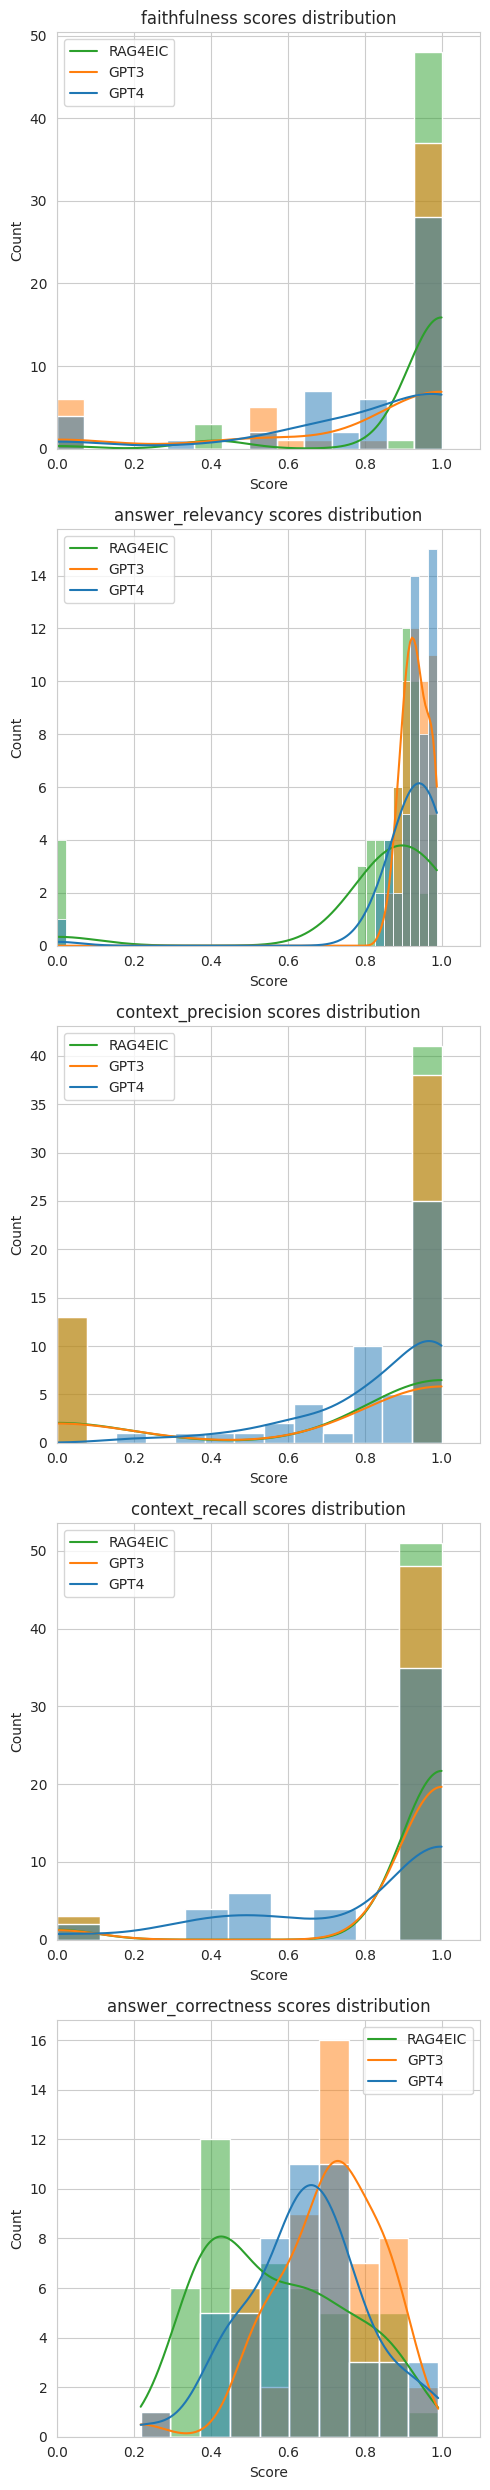

In [63]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
def analysis(df_list, labels = ["RAG4EIC"]):
  sns.set_style("whitegrid")
  df = df_list[0]
  fig, axs = plt.subplots(df.columns.size, 1, figsize=(5, 5*df.columns.size))
  colors = ["orange", "blue", "green"]
  for i,col in enumerate(df.columns):
    #sns.kdeplot(data=[df[col].values],legend=False,ax=axs[i],fill=True)
    sns.histplot(data=[df[col].values for df in df_list], kde=True, ax=axs[i], color = colors, alpha = 0.5)
    axs[i].set_title(f'{col} scores distribution')
    axs[i].legend(labels=labels)
    axs[i].set_xlabel("Score")
    axs[i].set_xlim(0., 1.1)
  plt.tight_layout()
  plt.show()

columns = ['faithfulness', 'answer_relevancy', 'context_precision', 'context_recall', 'answer_correctness']
result_df = pd.read_csv(f"results_k_{max_k}_sim_{sim_score}.csv", sep = ",")[columns]
gpt3_df = pd.read_csv(f"results_gpt3.csv", sep = ",")[columns]
gpt4_df = pd.read_csv(f"results_gpt4.csv", sep = ",")[columns]
analysis(
    [result_df, gpt3_df, gpt4_df],
    ["RAG4EIC", "GPT3", "GPT4"]
) 


In [64]:
result_df.describe()

,faithfulness,answer_relevancy,context_precision,context_recall,answer_correctness
count,50.000000,51.000000,51.000000,51.000000,50.000000
mean,0.806667,0.917499,0.853330,0.825163,0.648300
std,0.292983,0.137288,0.189823,0.286868,0.156399
min,0.000000,0.000000,0.200000,0.000000,0.220994
25%,0.666667,0.915960,0.789909,0.666667,0.589512
50%,1.000000,0.936304,0.906041,1.000000,0.656448
75%,1.000000,0.975907,1.000000,1.000000,0.731014
max,1.000000,0.987759,1.000000,1.000000,0.991181


In [48]:
gpt3_df.describe()

,faithfulness,answer_relevancy,context_precision,context_recall,answer_correctness
count,51.000000,51.000000,51.000000,51.000000,51.000000
mean,0.814472,0.932808,0.745098,0.941176,0.708106
std,0.341448,0.034111,0.440143,0.237635,0.136703
min,0.000000,0.851863,0.000000,0.000000,0.217547
25%,0.733333,0.907381,0.500000,1.000000,0.613812
50%,1.000000,0.933145,1.000000,1.000000,0.728037
75%,1.000000,0.960281,1.000000,1.000000,0.818720
max,1.000000,0.987759,1.000000,1.000000,0.915471


In [49]:
gpt4_df.describe()

,faithfulness,answer_relevancy,context_precision,context_recall,answer_correctness
count,53.000000,54.000000,54.000000,54.000000,53.000000
mean,0.945013,0.828640,0.759259,0.944444,0.574778
std,0.191487,0.241862,0.431548,0.231212,0.182230
min,0.000000,0.000000,0.000000,0.000000,0.317134
25%,1.000000,0.843516,1.000000,1.000000,0.407905
50%,1.000000,0.903214,1.000000,1.000000,0.544670
75%,1.000000,0.924854,1.000000,1.000000,0.719682
max,1.000000,0.986122,1.000000,1.000000,0.943232


In [61]:
gpt3_df = pd.read_csv(f"results_gpt3.csv", sep = ",")[["answer", "ground_truth"]]
print (gpt3_df.loc[0].answer)
print (gpt3_df.loc[0].ground_truth)

The main detectors proposed for the Electron-Ion Collider (EIC) include:

1. Tracking detectors: These detectors are used to measure the trajectories of charged particles produced in collisions at the EIC.

2. Calorimeters: Calorimeters are used to measure the energy of particles produced in collisions at the EIC.

3. Cherenkov detectors: Cherenkov detectors are used to detect and measure the velocity of charged particles produced in collisions at the EIC.

The optical processes involved in Cherenkov detectors include the emission of Cherenkov radiation when a charged particle travels through a medium at a speed greater than the speed of light in that medium. This radiation forms a cone of light with a characteristic angle that can be measured to determine the velocity of the particle.

AI is being utilized for imaging Cherenkov detectors at EIC by using machine learning algorithms to analyze and interpret the data collected by the detectors. This can help in improving the efficiency a

In [53]:
gpt3_df[["answer", "ground_truth"]]

KeyError: "None of [Index(['answer', 'ground_truth'], dtype='object')] are in the [columns]"

In [54]:
gpt3_df.columns

Index(['faithfulness', 'answer_relevancy', 'context_precision',
       'context_recall', 'answer_correctness'],
      dtype='object')